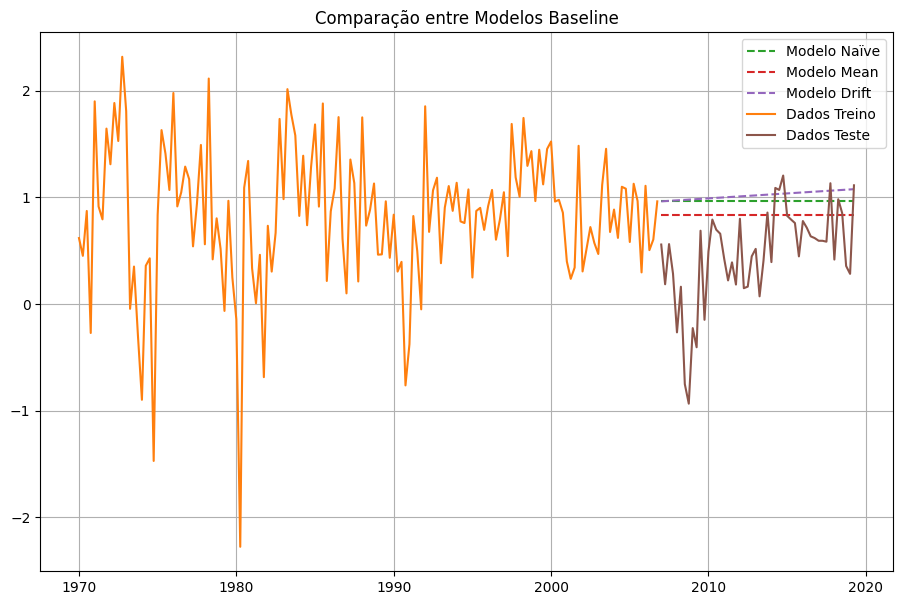

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_csv('./us_change.csv')
df = (df
    .assign(date=pd.PeriodIndex(df.Quarter.str.replace(' ', ''), freq='Q').to_timestamp())
    .set_index('date'))
df = df.asfreq('QS-OCT')

# Seleção da variável target
target = 'Consumption'

# Dividir os dados em treino e teste
train_size = int(len(df) * 0.75)  # 75% treino, 25% teste
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Modelo Baseline Mean
mean_preds = np.repeat(train[target].mean(), len(test))  # Média do treino como previsão

# Modelo Baseline Naïve
naive_preds = np.repeat(train[target].iloc[-1], len(test))  # Último valor como previsão

# Modelo Baseline Drift
drift_preds = np.arange(len(test)) * (train[target].iloc[-1] - train[target].iloc[0]) / len(train) + train[target].iloc[-1]

# Visualizar os resultados
plt.figure(figsize=(11, 7))
plt.plot(test.index, naive_preds, label="Modelo Naïve", linestyle="--", color='C2')
plt.plot(test.index, mean_preds, label="Modelo Mean", linestyle="--", color='C3')
plt.plot(test.index, drift_preds, label="Modelo Drift", linestyle="--", color='C4')
plt.plot(train[target], label="Dados Treino", color='C1')
plt.plot(test[target], label="Dados Teste", color='C5')

# Ajustes finais no gráfico
plt.title("Comparação entre Modelos Baseline")
plt.legend()
plt.grid(True)
plt.show()




In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Função para calcular as métricas de erro
def pred_summary(y, pred, label):
    # Calcular R²
    r2 = r2_score(y, pred)
    # Calcular Adjusted R²
    n = len(y)  # Número de observações
    p = 1  # Número de variáveis independentes, assumindo que o modelo tem uma variável de entrada
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    summary = {
        "RMSE": np.sqrt(np.mean((pred - y) ** 2)),   # Root Mean Squared Error
        "MAE": np.mean(np.abs(pred - y)),             # Mean Absolute Error
        "MSE": np.mean((pred - y) ** 2),              # Mean Squared Error
        "R²": r2,                                     # Coeficiente de Determinação
        "Adjusted R²": adj_r2,                       # Coeficiente de Determinação Ajustado
        "No. Observations": len(pred)                 # Número de observações
    }
    return pd.DataFrame(summary, index=[label])

# Função para comparar os modelos
def compare(y, preds, strs):
    comp = pred_summary(y, preds[0], strs[0])
    for i in range(1, len(preds)):
        comp = comp._append(pred_summary(y, preds[i], strs[i]))
    return comp

# Modelos baseline
mean_preds = np.repeat(train[target].mean(), len(test))  # Média do treino como previsão
naive_preds = np.repeat(train[target].iloc[-1], len(test))  # Último valor como previsão
drift_preds = np.arange(len(test)) * (train[target].iloc[-1] - train[target].iloc[0]) / len(train) + train[target].iloc[-1]  # Drift

# Lista de previsões e rótulos
preds = [mean_preds, naive_preds, drift_preds]
strs = ["Modelo Mean", "Modelo Naïve", "Modelo Drift"]

# Comparar os modelos
compare(test[target], preds, strs)



,RMSE,MAE,MSE,R²,Adjusted R²,No. Observations
Modelo Mean,0.582600,0.436599,0.339423,-0.688545,-0.723723,50
Modelo Naïve,0.670611,0.531336,0.449719,-1.237240,-1.283849,50
Modelo Drift,0.703241,0.570622,0.494547,-1.460249,-1.511504,50


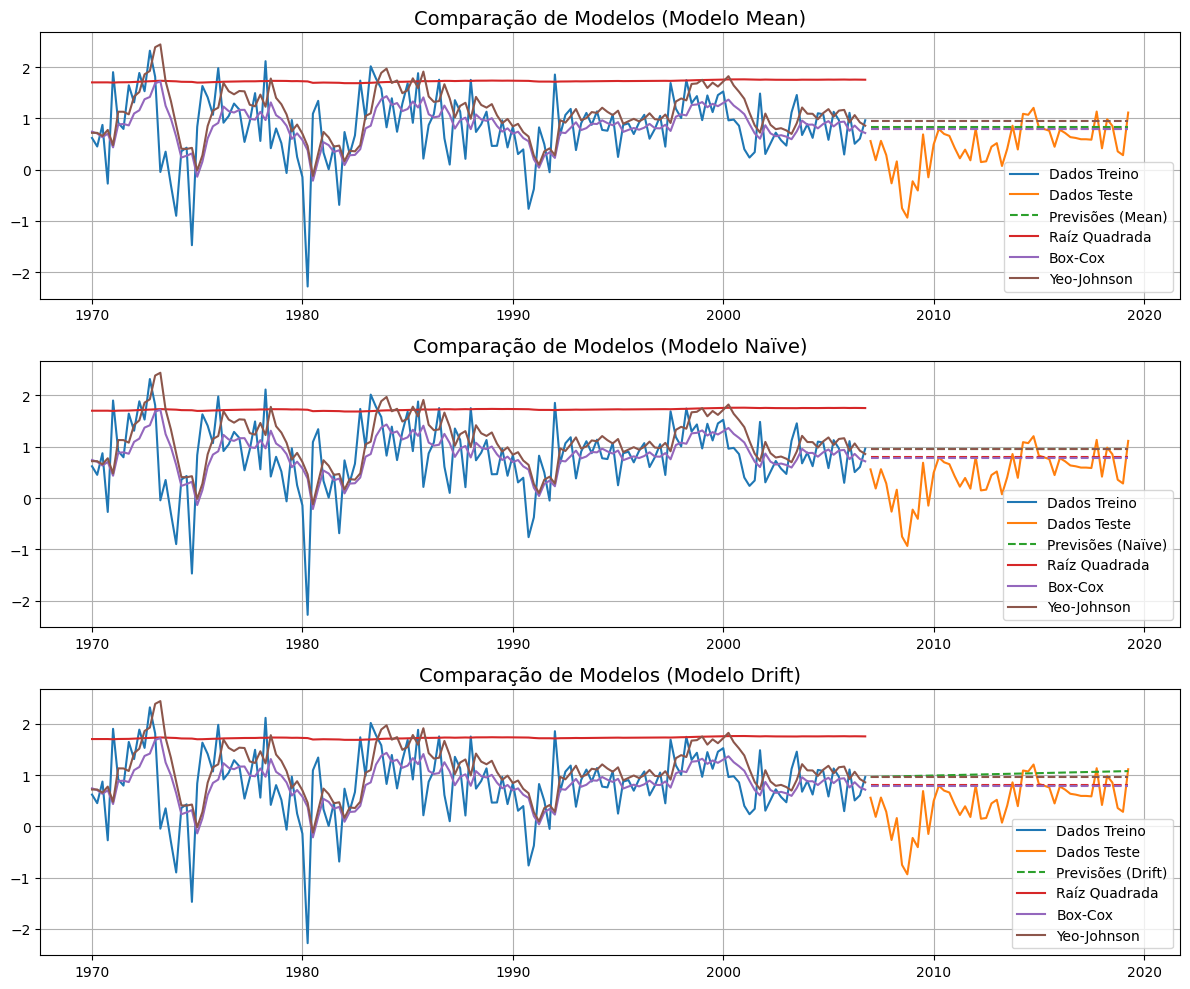

In [15]:
# Ajuste para garantir valores positivos
offset = abs(train[target].min()) + 1e-5  # Garantir valores positivos
train_adj = train[target] + offset

# Função para modelar e prever com Exponential Smoothing
def fit_predict_model(train_data, test_length):
    model = sm.tsa.SimpleExpSmoothing(train_data).fit()
    return model.fittedvalues, model.forecast(test_length)

# Modelo Baseline Mean
mean_preds = np.repeat(train[target].mean(), len(test))  # Média do treino como previsão

# Modelo Baseline Naïve
naive_preds = np.repeat(train[target].iloc[-1], len(test))  # Último valor como previsão

# Modelo Baseline Drift
drift_preds = np.arange(len(test)) * (train[target].iloc[-1] - train[target].iloc[0]) / len(train) + train[target].iloc[-1]  # Drift

# Gráfico de comparação das previsões com transformações
plt.figure(figsize=(12, 10))

# Comparando o Modelo Baseline Mean
plt.subplot(3, 1, 1)
plt.plot(train[target], label="Dados Treino", color='C0')
plt.plot(test[target], label="Dados Teste", color='C1')
plt.plot(test.index, mean_preds, label="Previsões (Mean)", linestyle="--", color='C2')

# Raiz Quadrada
train_sqrt = np.sqrt(train_adj)  # Aplica a transformação raiz quadrada
sqrt_train, sqrt_preds = fit_predict_model(train_sqrt, len(test))
sqrt_preds = np.square(sqrt_preds) - offset
plt.plot(sqrt_train, label="Raíz Quadrada", color='C3')
plt.plot(test.index, sqrt_preds, color='C3', linestyle="--")

# Box-Cox
model_box = sm.tsa.ExponentialSmoothing(train_adj, use_boxcox=True).fit()
box_train = model_box.fittedvalues - offset
box_preds = model_box.forecast(len(test)) - offset
plt.plot(box_train, label="Box-Cox", color='C4')
plt.plot(test.index, box_preds, color='C4', linestyle="--")

# Yeo-Johnson
train_yj, lambda_yj = stats.yeojohnson(train[target])  # Aplica a transformação Yeo-Johnson
model_yj = sm.tsa.SimpleExpSmoothing(train_yj).fit()
yj_train = model_yj.fittedvalues
yj_preds = model_yj.forecast(len(test))
plt.plot(train.index, yj_train, label="Yeo-Johnson", color='C5')
plt.plot(test.index, yj_preds, color='C5', linestyle="--")

plt.title("Comparação de Modelos (Modelo Mean)", fontsize=14)
plt.legend()
plt.grid(True)

# Comparando o Modelo Baseline Naïve
plt.subplot(3, 1, 2)
plt.plot(train[target], label="Dados Treino", color='C0')
plt.plot(test[target], label="Dados Teste", color='C1')
plt.plot(test.index, naive_preds, label="Previsões (Naïve)", linestyle="--", color='C2')

# Raiz Quadrada
sqrt_train, sqrt_preds = fit_predict_model(train_sqrt, len(test))
sqrt_preds = np.square(sqrt_preds) - offset
plt.plot(sqrt_train, label="Raíz Quadrada", color='C3')
plt.plot(test.index, sqrt_preds, color='C3', linestyle="--")

# Box-Cox
box_train = model_box.fittedvalues - offset
box_preds = model_box.forecast(len(test)) - offset
plt.plot(box_train, label="Box-Cox", color='C4')
plt.plot(test.index, box_preds, color='C4', linestyle="--")

# Yeo-Johnson
yj_train = model_yj.fittedvalues
yj_preds = model_yj.forecast(len(test))
plt.plot(train.index, yj_train, label="Yeo-Johnson", color='C5')
plt.plot(test.index, yj_preds, color='C5', linestyle="--")

plt.title("Comparação de Modelos (Modelo Naïve)", fontsize=14)
plt.legend()
plt.grid(True)

# Comparando o Modelo Baseline Drift
plt.subplot(3, 1, 3)
plt.plot(train[target], label="Dados Treino", color='C0')
plt.plot(test[target], label="Dados Teste", color='C1')
plt.plot(test.index, drift_preds, label="Previsões (Drift)", linestyle="--", color='C2')

# Raiz Quadrada
sqrt_train, sqrt_preds = fit_predict_model(train_sqrt, len(test))
sqrt_preds = np.square(sqrt_preds) - offset
plt.plot(sqrt_train, label="Raíz Quadrada", color='C3')
plt.plot(test.index, sqrt_preds, color='C3', linestyle="--")

# Box-Cox
box_train = model_box.fittedvalues - offset
box_preds = model_box.forecast(len(test)) - offset
plt.plot(box_train, label="Box-Cox", color='C4')
plt.plot(test.index, box_preds, color='C4', linestyle="--")

# Yeo-Johnson
yj_train = model_yj.fittedvalues
yj_preds = model_yj.forecast(len(test))
plt.plot(train.index, yj_train, label="Yeo-Johnson", color='C5')
plt.plot(test.index, yj_preds, color='C5', linestyle="--")

plt.title("Comparação de Modelos (Modelo Drift)", fontsize=14)
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Função para calcular as métricas de erro
def pred_summary(y, pred, label):
    # Calcular R²
    r2 = r2_score(y, pred)
    # Calcular Adjusted R²
    n = len(y)  # Número de observações
    p = 1  # Número de variáveis independentes, assumindo que o modelo tem uma variável de entrada
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    summary = {
        "RMSE": np.sqrt(np.mean((pred - y) ** 2)),   # Root Mean Squared Error
        "MAE": np.mean(np.abs(pred - y)),             # Mean Absolute Error
        "MSE": np.mean((pred - y) ** 2),              # Mean Squared Error
        "R²": r2,                                     # Coeficiente de Determinação
        "Adjusted R²": adj_r2,                       # Coeficiente de Determinação Ajustado
        "No. Observations": len(pred)                 # Número de observações
    }
    return pd.DataFrame(summary, index=[label])

# Função para comparar os modelos
def compare(y, preds, strs):
    comp = pred_summary(y, preds[0], strs[0])
    for i in range(1, len(preds)):
        comp = comp._append(pred_summary(y, preds[i], strs[i]))
    return comp

# Definição das previsões dos modelos com e sem transformações
# Modelos baselines: exp_preds (sem transformação), sqrt_preds, box_preds, yj_preds
preds = [exp_preds, sqrt_preds, box_preds, yj_preds]
strs = ["Sem Transf", "Raíz Quadrada", "Box-Cox", "Yeo-Johnson"]

# Comparar as previsões com as métricas para cada modelo (Mean, Naïve, Drift)
mean_preds = np.repeat(train[target].mean(), len(test))  # Previsão do Modelo Mean
naive_preds = np.repeat(train[target].iloc[-1], len(test))  # Previsão do Modelo Naïve
drift_preds = np.arange(len(test)) * (train[target].iloc[-1] - train[target].iloc[0]) / len(train) + train[target].iloc[-1]  # Previsão do Modelo Drift

# Comparar para o Modelo Mean
print("Métricas para o Modelo Mean:")
metrics_mean = compare(test[target], [mean_preds] + preds, ["Mean"] + strs)
print(metrics_mean)

# Comparar para o Modelo Naïve
print("\nMétricas para o Modelo Naïve:")
metrics_naive = compare(test[target], [naive_preds] + preds, ["Naïve"] + strs)
print(metrics_naive)

# Comparar para o Modelo Drift
print("\nMétricas para o Modelo Drift:")
metrics_drift = compare(test[target], [drift_preds] + preds, ["Drift"] + strs)
print(metrics_drift)


Métricas para o Modelo Mean:
                   RMSE       MAE       MSE        R²  Adjusted R²  \
Mean           0.582600  0.436599  0.339423 -0.688545    -0.723723   
Sem Transf     0.550465  0.403867  0.303011 -0.507406    -0.538810   
Raíz Quadrada  0.560852  0.413783  0.314555 -0.564829    -0.597430   
Box-Cox        0.552619  0.405790  0.305387 -0.519225    -0.550876   
Yeo-Johnson    0.665096  0.525680  0.442352 -1.200590    -1.246435   

               No. Observations  
Mean                         50  
Sem Transf                   50  
Raíz Quadrada                50  
Box-Cox                      50  
Yeo-Johnson                  50  

Métricas para o Modelo Naïve:
                   RMSE       MAE       MSE        R²  Adjusted R²  \
Naïve          0.670611  0.531336  0.449719 -1.237240    -1.283849   
Sem Transf     0.550465  0.403867  0.303011 -0.507406    -0.538810   
Raíz Quadrada  0.560852  0.413783  0.314555 -0.564829    -0.597430   
Box-Cox        0.552619  0.405790  

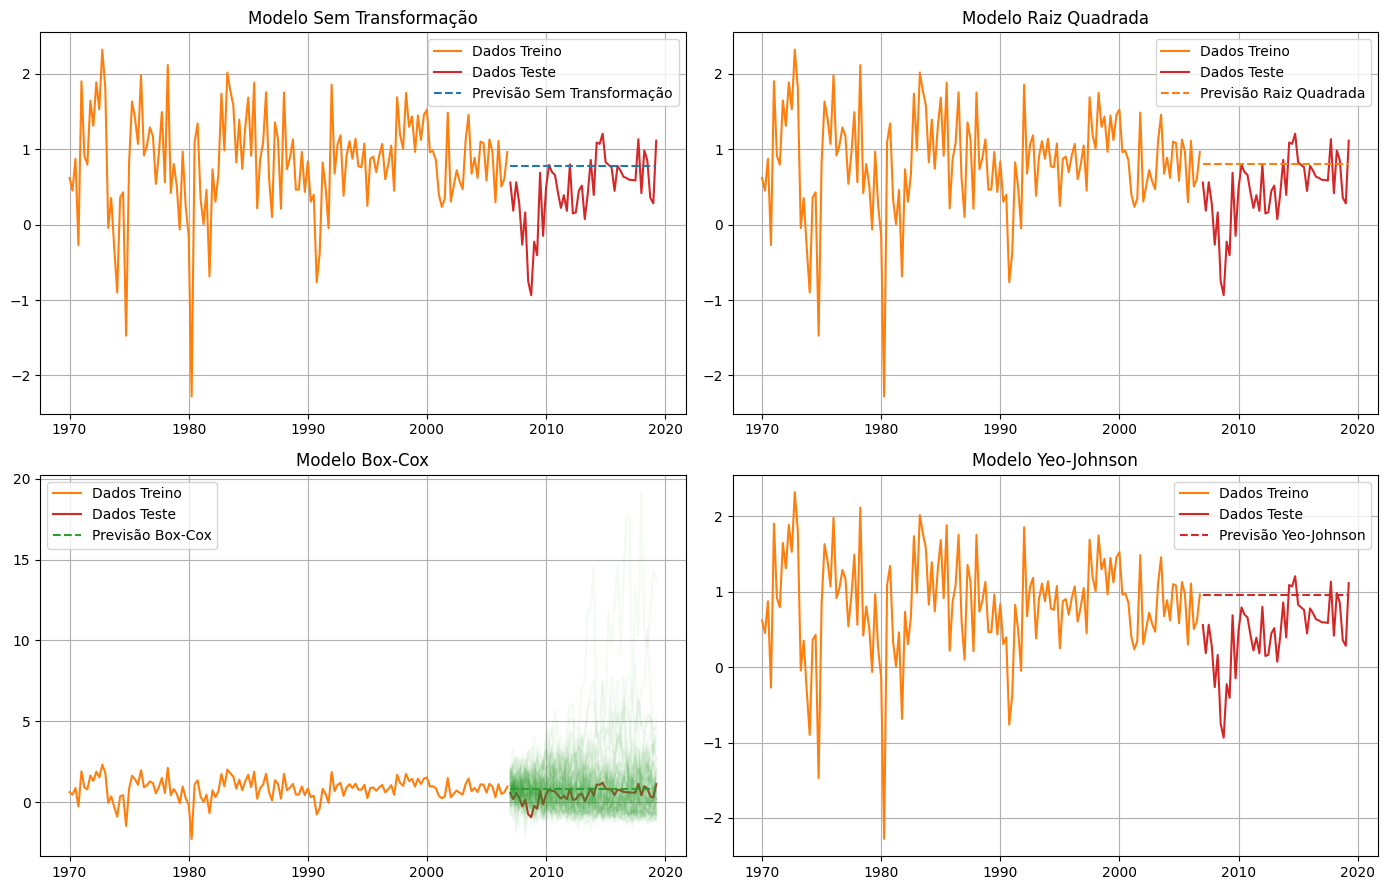

In [20]:
# Visualizar previsões e simulações de cada modelo
plt.figure(figsize=(14, 9))

# Modelo Sem Transformação
plt.subplot(2, 2, 1)
plt.plot(train[target], label="Dados Treino", color='C1')
plt.plot(test[target], label="Dados Teste", color='C3')
plt.plot(test.index, exp_preds, label="Previsão Sem Transformação", linestyle="--", color='C0')
plt.title("Modelo Sem Transformação")
plt.legend()
plt.grid()

# Modelo Raiz Quadrada
plt.subplot(2, 2, 2)
plt.plot(train[target], label="Dados Treino", color='C1')
plt.plot(test[target], label="Dados Teste", color='C3')
plt.plot(test.index, sqrt_preds, label="Previsão Raiz Quadrada", linestyle="--", color='C1')
plt.title("Modelo Raiz Quadrada")
plt.legend()
plt.grid()

# Modelo Box-Cox
plt.subplot(2, 2, 3)
simulations_box = model_box.simulate(len(test), repetitions=99, error="mul") - offset
plt.plot(train[target], label="Dados Treino", color='C1')
plt.plot(test[target], label="Dados Teste", color='C3')
plt.plot(test.index, box_preds, label="Previsão Box-Cox", linestyle="--", color='C2')
plt.plot(test.index, simulations_box, alpha=0.05, color='C2')  # Simulações
plt.title("Modelo Box-Cox")
plt.legend()
plt.grid()

# Modelo Yeo-Johnson
plt.subplot(2, 2, 4)
plt.plot(train[target], label="Dados Treino", color='C1')
plt.plot(test[target], label="Dados Teste", color='C3')
plt.plot(test.index, yj_preds, label="Previsão Yeo-Johnson", linestyle="--", color='C3')
plt.title("Modelo Yeo-Johnson")
plt.legend()
plt.grid()

# Ajustar layout e exibir
plt.tight_layout()
plt.show()


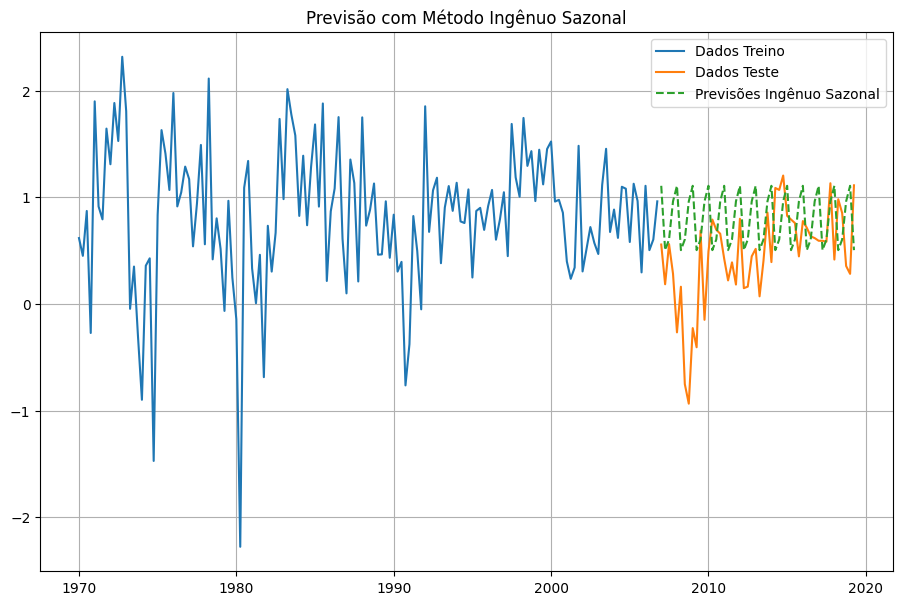

                   RMSE       MAE       MSE        R²  Adjusted R²  \
Naïve Sazonal  0.625482  0.492725  0.391228 -0.946258    -0.986805   

               No. Observations  
Naïve Sazonal                50  


In [18]:
def naive_seasonal_forecast(train, test, target, seasonal_period):
    """
    Implementa o método ingênuo com sazonalidade.

    Parâmetros:
        - train: Dados de treino (DataFrame).
        - test: Dados de teste (DataFrame).
        - target: Nome da variável target (string).
        - seasonal_period: Período sazonal (int, ex: 4 para trimestral, 12 para mensal).

    Retorna:
        - previsões para o conjunto de teste.
    """
    # Extrai os últimos valores de treino com base no período sazonal
    last_season = train[target].iloc[-seasonal_period:]
    repetitions = int(np.ceil(len(test) / seasonal_period))

    # Repete os valores sazonais para cobrir o período de teste
    seasonal_preds = np.tile(last_season, repetitions)[:len(test)]
    return seasonal_preds

# Parâmetros do modelo sazonal
seasonal_period = 4  # Ajuste este valor de acordo com os seus dados (ex.: 4 para trimestral, 12 para mensal)
target = "Consumption"

# Previsões usando o método sazonal
naive_seasonal_preds = naive_seasonal_forecast(train, test, target, seasonal_period)

# Visualizando as previsões
plt.figure(figsize=(11, 7))
plt.plot(train[target], label="Dados Treino", color="C0")
plt.plot(test[target], label="Dados Teste", color="C1")
plt.plot(test.index, naive_seasonal_preds, label="Previsões Ingênuo Sazonal", linestyle="--", color="C2")
plt.title("Previsão com Método Ingênuo Sazonal")
plt.legend()
plt.grid()
plt.show()

# Métricas para o método sazonal
metrics_seasonal = pred_summary(test[target], naive_seasonal_preds, "Naïve Sazonal")
print(metrics_seasonal)
